In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

## What is a recommendation engine?
---

At its most basic: A system designed to match users to things that they will like.

- The "things" can be products, brands, media, or even other people. 
- Ideally, they should be things the user doesn't know about. 
- **The goal is to rank all the possible things that are available to the user and to only present the top items**

### Explicit data vs Implicit data

#### Explicit
- Explicity given/pro-actively acquired
- Clear signals
- Cost associated with acquisition (time/cognitive)
- Limited and sparse data because of this


#### Implicit
- Provided/collected passively (digital exhaust)
- Signals can be difficult to interpret
- Enormous quantities

### Two classical recommendation methods

- **Collaborative Filtering**: _(similar people)_
    - If you like the same 5 movies as someone else, you'll likely enjoy other movies they like.
    - There are two main types: (a) Find users who are similar and recommend what they like (**user-based**), or (b) recommend items that are similar to already-liked items (**item-based**).
   

- **Content-Based Filtering** _(similar items)_
    - If you enjoy certain characteristics of movies (e.g. certain actors, genre, etc.), you'll enjoy other movies with those characteristics.
    - Note this can easily be done using machine learning methods! Each movie can be decomposed into features. Then, for each user we compute a model -- the target can be a binary classifier (e.g. "LIKE"/"DISLIKE") or regression (e.g. star rating).

# Part 1. User-based Collaborative Filtering
---
This is the person who is most similar to you based upon the ratings both of you have given to a mix of products.

In [2]:
movies = ["user", "Friday the 13th", "Nightmare on Elm St", "Dawn of the Dead", "Hiro Dreams of Sushi", "180 South", "Exit Through the Giftshop"]
users = [
    ("Chuck", 5, 4, None, None, None, 1),
    ("Nancy", 5, None, 4, None, 2, None),
    ("Anya", 4, 5, 5, None, 1, None),
    ("Divya", 1, None, 2, 5, 4, 5),
    ("Pat", 1, 1, 1, None, 3, 4),
]

users = pd.DataFrame(users, columns=movies)
users = users.set_index("user")
users

,Friday the 13th,Nightmare on Elm St,Dawn of the Dead,Hiro Dreams of Sushi,180 South,Exit Through the Giftshop
user,,,,,,
Chuck,5,4.0,NaN,NaN,NaN,1.0
Nancy,5,NaN,4.0,NaN,2.0,NaN
Anya,4,5.0,5.0,NaN,1.0,NaN
Divya,1,NaN,2.0,5.0,4.0,5.0
Pat,1,1.0,1.0,NaN,3.0,4.0


## Cosine Similarity

<a id="formula"></a>
If we want to find the users most similar to user A, we need a **similarity metric**.

One metric we can use is **cosine similarity**. Cosine similarity uses the cosine between two vectors to compute a scalar value that represents how closely related these vectors are. 

## $$
cos(\theta) = \frac{\vec{Chuck} \cdot \vec{Nancy}}{\left\| \vec{Chuck}\right\| \left\| \vec{Nancy}\right\| } \
= \frac{\sum{Chuck_i Nancy_i}}{\sqrt{\sum{Chuck_i^2}}\sqrt{\sum{Nancy_i^2}}}
$$

- Angle of $0^{\circ}$ (same direction): $\cos(0^{\circ}) = 1$. Perfectly similar.
- Angle of $90^{\circ}$ (orthogonal): $\cos(90^{\circ}) = 0$. Totally dissimilar.
- Angle of $180^{\circ}$ (opposite direction): $\cos(90^{\circ}) = -1$. Opposite.


Doesn't this sound a lot like the correlation coefficient? It turns out that cosine similarity is identical to the **uncentered correlation coefficient**! As a bonus, if the points are mean-centered, then this formula also depicts the **Pearson correlation coefficient**.

In [3]:
def mean_center_rows(df):
    return (df.T - df.mean(axis=1)).T

users_mc = mean_center_rows(users)
users_mc

,Friday the 13th,Nightmare on Elm St,Dawn of the Dead,Hiro Dreams of Sushi,180 South,Exit Through the Giftshop
user,,,,,,
Chuck,1.666667,0.666667,NaN,NaN,NaN,-2.333333
Nancy,1.333333,NaN,0.333333,NaN,-1.666667,NaN
Anya,0.250000,1.250000,1.250000,NaN,-2.750000,NaN
Divya,-2.400000,NaN,-1.400000,1.6,0.600000,1.600000
Pat,-1.000000,-1.000000,-1.000000,NaN,1.000000,2.000000


In [4]:
users_mc = users_mc.fillna(0)
users_mc

,Friday the 13th,Nightmare on Elm St,Dawn of the Dead,Hiro Dreams of Sushi,180 South,Exit Through the Giftshop
user,,,,,,
Chuck,1.666667,0.666667,0.000000,0.0,0.000000,-2.333333
Nancy,1.333333,0.000000,0.333333,0.0,-1.666667,0.000000
Anya,0.250000,1.250000,1.250000,0.0,-2.750000,0.000000
Divya,-2.400000,0.000000,-1.400000,1.6,0.600000,1.600000
Pat,-1.000000,-1.000000,-1.000000,0.0,1.000000,2.000000


In [5]:
Chuck_mc = users_mc.loc['Chuck',:].values.reshape(1,-1)
Nancy_mc = users_mc.loc['Nancy',:].values.reshape(1,-1)
Divya_mc = users_mc.loc['Divya',:].values.reshape(1,-1)

print('Chuck vs. Nancy = ', cosine_similarity(Chuck_mc, Nancy_mc))
print('Chuck vs. Divya = ', cosine_similarity(Chuck_mc, Divya_mc))

Chuck vs. Nancy =  [[0.34942828]]
Chuck vs. Divya =  [[-0.72302567]]


In [6]:
sim_matrix = cosine_similarity(users_mc)
users_sim = pd.DataFrame(sim_matrix, columns=users_mc.index, index=users_mc.index)
users_sim

user,Chuck,Nancy,Anya,Divya,Pat
user,,,,,
Chuck,1.000000,0.349428,0.129503,-0.723026,-0.840673
Nancy,0.349428,1.000000,0.752993,-0.594588,-0.545545
Anya,0.129503,0.752993,1.000000,-0.335791,-0.593080
Divya,-0.723026,-0.594588,-0.335791,1.000000,0.739574
Pat,-0.840673,-0.545545,-0.593080,0.739574,1.000000


<AxesSubplot:xlabel='user', ylabel='user'>

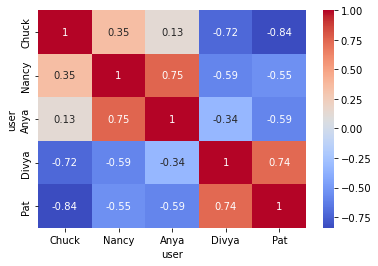

In [7]:
sns.heatmap(users_sim, annot=True, cmap='coolwarm')

**Will Nancy like Nightmare on Elm St?**

To answer this we will predict Nancy's rating using the _weighted results of the other users_.

This is where a little art comes in... let's make the decision to only include users that have a positive similarity score relative to Nancy.

The gist of what we want to do is given by the following formulaL

$$\frac{(\text{Chuck-Nancy sim})(\text{Chuck rating}) + (\text{Nancy-Anya sim})(\text{Anya ratings})}{\text{sum of similarities}}$$

$$= \frac{0.349428 \cdot (4) + 0.129503 \cdot (5)}{0.349428 + 0.129503} = 4.68$$

Here's the procedure for recommending movie X to Nancy:

1. Get Nancy's similarity scores to all other **users**.
2. Only keep positive similarities.  (This step can be tweaked!)
3. Convert Nancy's similarities to _weights_ by dividing each similarity by the _total_ similarity.
4. Get all the other users' ratings for movie X.
5. Weight each user's rating by Nancy's similarity to that user.

In [8]:
# get Nancy's similarity scores
nancy_sim = users_sim['Nancy'].drop('Nancy')
nancy_sim = nancy_sim[nancy_sim > 0]
nancy_sim

user
Chuck    0.349428
Anya     0.752993
Name: Nancy, dtype: float64

In [9]:
# Turn Nancy's similarity scores to weights
nancy_weights = nancy_sim.values/np.sum(nancy_sim.values)
nancy_weights

array([0.3169643, 0.6830357])

In [10]:
# Get elm_st_ratings
elm_st_ratings = users['Nightmare on Elm St'].drop('Nancy').loc[nancy_sim.index]
elm_st_ratings

user
Chuck    4.0
Anya     5.0
Name: Nightmare on Elm St, dtype: float64

In [11]:
np.dot(elm_st_ratings.values, nancy_weights)

4.683035701380843

How would we get expected ratings for all of the movies that Nancy has not seen?

In [14]:
ratings = users.T
ratings = ratings[ratings['Nancy'].isnull()]
ratings = ratings.drop('Nancy', axis=1)
ratings = ratings[nancy_sim.index]

nancy_ratings = np.dot(ratings.fillna(0).values, nancy_weights)
nancy_ratings

array([4.6830357, 0.       , 0.3169643])

In [15]:
pd.DataFrame(nancy_ratings, index=ratings.index)

,0
Nightmare on Elm St,4.683036
Hiro Dreams of Sushi,0.000000
Exit Through the Giftshop,0.316964


## Problems with user-based filtering
- Frequently-liked items will necessarily have users who like all kinds of other items. So, recommendations based on frequently-liked items may be inaccurate.

- User-based filtering also suffers from the **cold-start problem**. If a new user joins and has very few likes, then it is difficult to pair them with a similar user.

- Lastly, suppose that a user with few likes adds a new like. This may significantly change the recommendations. Hence, as users add likes, the recommendations must be continually and quickly updated.

# Part 2. Item-based Collaborative Filtering

In item-based filtering, we are trying to find similarities across items rather than users.

> Rather than looking for _similar users_, we are going to look for _similar movies/items_.  Similar items are determined by user rating patterns.

Basically, everything here is the same as in user-based collaborative filtering, except we will deal with the _transpose_ or our data matrix.

Just as in user-based filtering, we need to center our values by row.

In [16]:
sim_matrix = cosine_similarity(mean_center_rows(users.T).fillna(0))
movies_sim = pd.DataFrame(sim_matrix, columns=users.T.index, index=users.T.index)
movies_sim

,Friday the 13th,Nightmare on Elm St,Dawn of the Dead,Hiro Dreams of Sushi,180 South,Exit Through the Giftshop
Friday the 13th,1.000000,0.635369,0.771517,0.0,-0.709208,-0.773492
Nightmare on Elm St,0.635369,1.000000,0.859338,0.0,-0.557007,-0.358974
Dawn of the Dead,0.771517,0.859338,1.000000,0.0,-0.848528,-0.322252
Hiro Dreams of Sushi,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
180 South,-0.709208,-0.557007,-0.848528,0.0,1.000000,0.430414
Exit Through the Giftshop,-0.773492,-0.358974,-0.322252,0.0,0.430414,1.000000


<AxesSubplot:>

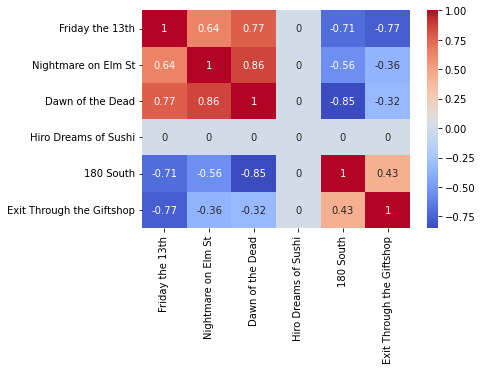

In [18]:
sns.heatmap(movies_sim, annot=True, cmap='coolwarm')

The nearest movies to _Nightmare on Elm St_ are _Firday the 13th_ and _Dawn of the Dead_. To calculate Nancy's rating for our _Nightmare on Elm St_, we have the following equation:

** (1st closest cosine sim movie x Nancy's rating + 2nd closest cosine sim movie x Nancy's product rating) / (sum of 1st and 2nd's cosine sims) **

$$\frac{(\text{Dawn of Dead sim})(\text{Nancy's rating}) + (\text{Friday 13 sim})(\text{Nancy's rating})}{\text{sum of similarities}} = \frac{0.859338 \cdot (4) + 0.635369 \cdot (5)}{0.859338 + 0.635369} = 4.43$$

Here's the procedure for recommending movie X to Nancy:

1. Get movie X's similarity scores to all other **movies**.
2. Only keep positive similarities.  (This step can be tweaked!)
3. Convert movie X's similarities to _weights_ by dividing each similarity by the _total_ similarity.
4. Get Nancy's ratings for all other movies.
5. Weight Nancy's ratings for all other movies by movie X's similarity to those movies.

In [19]:
# get Elm St similarity scores
elm_st_sim = movies_sim['Nightmare on Elm St'].drop('Nightmare on Elm St')
elm_st_sim = elm_st_sim[elm_st_sim > 0]
elm_st_sim

Friday the 13th     0.635369
Dawn of the Dead    0.859338
Name: Nightmare on Elm St, dtype: float64

In [20]:
# Turn Elm St similarity scores to weights
elm_st_weights = elm_st_sim.values/np.sum(elm_st_sim.values)
elm_st_weights

array([0.42507927, 0.57492073])

In [21]:
# Get Nancy's_ratings
nancy_ratings = users.T['Nancy'].loc[elm_st_sim.index]
nancy_ratings

Friday the 13th     5.0
Dawn of the Dead    4.0
Name: Nancy, dtype: float64

In [22]:
np.dot(nancy_ratings.values, elm_st_weights)

4.425079267585091

## Part 3. Content-based Filtering

In [24]:
from sklearn.preprocessing import StandardScaler
import pandas as pd, numpy as np
import sqlite3
conn = sqlite3.connect("../db.sqlite3")
conn.text_factory = lambda x: str(x, 'latin1')

sql = """
SELECT r.userID, r.artistID, r.tagID, 
a.name AS artist,
t.tagValue as genre
FROM rec_user_artist_tags r
LEFT JOIN rec_artists a on r.artistID = a.id
LEFT JOIN rec_tags t on r.tagID = t.tagID
WHERE a.name NOT NULL
LIMIT 15000
"""

artists = pd.read_sql(sql, con=conn)
artist_genre = artists.groupby(["artist", "genre"]).size().sort_values(ascending=False).unstack().fillna(0)

In [25]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userID    15000 non-null  int64 
 1   artistID  15000 non-null  int64 
 2   tagID     15000 non-null  int64 
 3   artist    15000 non-null  object
 4   genre     15000 non-null  object
dtypes: int64(3), object(2)
memory usage: 586.1+ KB


In [26]:
artist_genre.head()

genre,'80s,00's,00s,1008,10s,1969,1970,1970's,1970s,1973,...,xenomania,xmas,xtina,xxxmas,ya,yay,yearns to be covered,yorkshire,you,zadrotstvo
artist,,,,,,,,,,,,,,,,,,,,,
:wumpscut:,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Agonoize,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aidan Baker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Air,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Basic similarity matrix

In [27]:
artist_sim = pd.DataFrame(
    cosine_similarity(artist_genre),
    columns=artist_genre.index,
    index=artist_genre.index
)